In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.utils import shuffle

In [2]:
# Input Folders
main_folder = 'dataset/traffic_object_detection'
train_folder = f'{main_folder}/train'
test_folder = f'{main_folder}/test'
valid_folder = f'{main_folder}/valid'

classes = ['bicycle', 'bus', 'car', 'motorbike', 'person']
colors = [[0, 255, 0], [255, 0, 0], [0, 255, 0], [200, 200, 0], [200, 200, 200]]

In [16]:
def upscale_points(image, coordinates, startFromZero= False):
    if startFromZero:
        x = int(coordinates[0] * image.shape[0])
        y = int(coordinates[1] * image.shape[1])
        width = int(coordinates[2] * image.shape[0])
        height = int(coordinates[3] * image.shape[1])
        return (y, x, height, width)
    else:
        x = int(coordinates[1] * image.shape[0])
        y = int(coordinates[2] * image.shape[1])
        width = int(coordinates[3] * image.shape[0])
        height = int(coordinates[4] * image.shape[1])
        return (int(coordinates[0]), y, x, height, width)

def draw_boundary(image, color, coordinates, startFromZero= False):
    if startFromZero:
        (x, y, width, height) = upscale_points(image, coordinates, startFromZero)
    else:
        (object_class, x, y, width, height) = upscale_points(image, coordinates, startFromZero)
    image[x-width:x+width, y-height:y-height+5, :] = color
    image[x+width:x+width+5, y-height:y+height, :] = color
    image[x-width:x+width, y+height-5:y+height, :] = color
    image[x-width-5:x-width, y-height:y+height, :] = color
    if startFromZero:
        return image
    else:
        return image, (int(coordinates[0]), x, y, width, height)

def clip(value, prev_min, prev_max, new_min, new_max):
    return int((((value - prev_min) * (new_max - new_min)) / (prev_max - prev_min)) + new_min)

def load_image(folder, images_list, labels_list, index):
    image = plt.imread(f'{folder}/images/{images_list[index]}')
    image = cv2.resize(image, (640, 640))
    object_coordinates = []
    with open(f'{folder}/labels/{labels_list[index]}', 'r') as file:
        label = file.readlines()
    for lab in label:
        coordinates = [float(num) for num in lab.split(' ')]
        #coords = upscale_points(image, coordinates)
        object_coordinates.append(coordinates)
    return image, object_coordinates

aguanambi-1085_png_jpg.rf.ba8bcc4fd6c7cae9f610e611e300bdf1.txt aguanambi-1085_png_jpg.rf.ba8bcc4fd6c7cae9f610e611e300bdf1.jpg


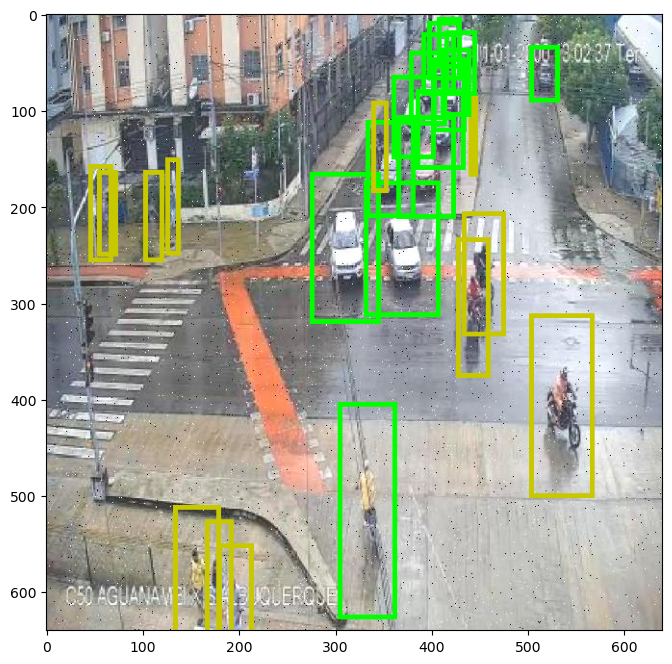

In [17]:
# Loading data
image_index = 5
images = os.listdir(f'{train_folder}/images')
labels = os.listdir(f'{train_folder}/labels')
image = plt.imread(f'{train_folder}/images/{images[image_index]}')
label = ''
object_coordinates = []
with open(f'{train_folder}/labels/{labels[image_index]}', 'r') as file:
    label = file.readlines()
new_image = image.copy()
for lab in label:
    coordinates = [float(num) for num in lab.split(' ')]
    new_image, coords = draw_boundary(new_image, colors[int(coordinates[0])], coordinates, False)
    object_coordinates.append(coords)

print(labels[image_index], images[image_index])

plt.figure(figsize=(8, 8))
plt.imshow(new_image)

In [18]:
# Checks whether the region goes out of the iamge at any side or not
def is_region_inside_image(image, region):
    x = region[1]
    y = region[2]
    width = region[3]
    height = region[4]

    if x - width < 0 or x + width > image.shape[0] or y - height < 0 or y + height > image.shape[1]:
        return False
    else:
        return True

In [19]:
def resize_region(image, coords, new_size = (64, 64)):
    x = coords[1]
    y = coords[2]
    width = coords[3]
    height = coords[4]
    cropped_image = image[x - width: x + width, y - height : y + height, :]
    cropped_image = cv2.resize(cropped_image, new_size)
    return cropped_image

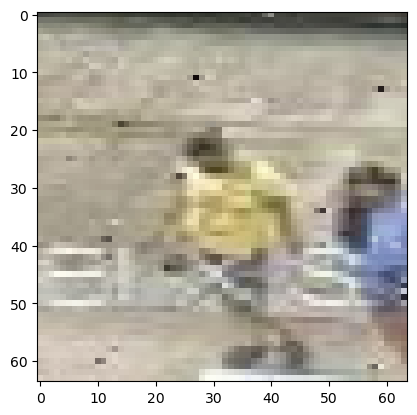

In [20]:
cropped_image = resize_region(image, object_coordinates[0])
plt.imshow(cropped_image)

# Data Generator

In [61]:
class ImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, folder, batch_size, shuffle=True):
        self.folder = folder
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.images = os.listdir(f'{folder}/images')
        self.labels = os.listdir(f'{folder}/labels')
        self.on_epoch_end()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.images, self.labels = shuffle(self.images, self.labels)

    def __len__(self):
        return int(len(self.images) / self.batch_size)

    def __getitem__(self, index):
        batch_images = self.images[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        X = []
        y1 = []
        y2 = []
        for i in range(self.batch_size):
            image, object_coordinates = load_image(self.folder, batch_images, batch_labels, i)
            for object_coords in object_coordinates:
                dimensions = upscale_points(image, object_coords, False)
                if not is_region_inside_image(image, dimensions):
                    continue

                cropped_image = resize_region(image, dimensions)
                X.append(cropped_image)
                y1.append(int(object_coords[0]))
                y2.append(object_coords[1:])

        X = np.asarray(X).astype('float32')
        X = X / 255.
        y = {
            'classifier': np.array(y1, dtype='int32'),
            'boundary_definer': np.array(y2, dtype='float32')
        }
        return X, y

In [62]:
train_generator = ImageGenerator(train_folder, 50, True)
valid_generator = ImageGenerator(valid_folder, 2)
test_generator = ImageGenerator(test_folder, 2)
for x, y in train_generator:
    print(y['boundary_definer'])
    break

[[0.6421875  0.3234375  0.146875   0.2640625 ]
 [0.06953125 0.6453125  0.0390625  0.1640625 ]
 [0.31484374 0.2796875  0.0625     0.0921875 ]
 ...
 [0.33515626 0.6        0.02890625 0.1265625 ]
 [0.6195313  0.34296876 0.0234375  0.1015625 ]
 [0.3953125  0.5125     0.028125   0.11171875]]


# Defining & Training Model

In [63]:
i = Input(shape=(64, 64, 3))
x = Conv2D(32, (3,3), activation='relu')(i)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(units=1024, activation='relu')(x)
x = Dense(units=128, activation='relu')(x)
out1 = Dense(units=len(classes), activation='softmax', name='classifier')(x)
x = Dense(units=64, activation='relu')(x)
x = Dense(units=32, activation='relu')(x)
out2 = Dense(units=4, activation='sigmoid', name='boundary_definer')(x)
model = Model(i, [out1, out2])
model.compile(loss={'classifier': 'sparse_categorical_crossentropy', 'boundary_definer': 'mean_squared_error'}, optimizer='adam', metrics={'classifier': 'accuracy', 'boundary_definer': 'accuracy'})
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_30 (Conv2D)             (None, 62, 62, 32)   896         ['input_11[0][0]']               
                                                                                                  
 max_pooling2d_30 (MaxPooling2D  (None, 31, 31, 32)  0           ['conv2d_30[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_31 (Conv2D)             (None, 29, 29, 32)   9248        ['max_pooling2d_30[0][0]']

In [64]:
history = model.fit(train_generator, epochs=20, steps_per_epoch=70, validation_data=valid_generator, validation_steps=20)

Epoch 1/20
70/70 [==============================] - 25s 351ms/step - loss: 0.9485 - classifier_loss: 0.9099 - boundary_definer_loss: 0.0386 - classifier_accuracy: 0.6234 - boundary_definer_accuracy: 0.6376 - val_loss: 0.7101 - val_classifier_loss: 0.6826 - val_boundary_definer_loss: 0.0275 - val_classifier_accuracy: 0.7137 - val_boundary_definer_accuracy: 0.6850
Epoch 2/20
70/70 [==============================] - 24s 347ms/step - loss: 0.5641 - classifier_loss: 0.5407 - boundary_definer_loss: 0.0234 - classifier_accuracy: 0.7955 - boundary_definer_accuracy: 0.6767 - val_loss: 0.4709 - val_classifier_loss: 0.4456 - val_boundary_definer_loss: 0.0253 - val_classifier_accuracy: 0.8500 - val_boundary_definer_accuracy: 0.6156
Epoch 3/20
70/70 [==============================] - 24s 336ms/step - loss: 0.4278 - classifier_loss: 0.4063 - boundary_definer_loss: 0.0216 - classifier_accuracy: 0.8572 - boundary_definer_accuracy: 0.6815 - val_loss: 0.4046 - val_classifier_loss: 0.3841 - val_boundary_

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (0,) where an element of shape (None, None, None, None) was expected.
Traceback (most recent call last):

  File "d:\Applications\Anaconda\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "d:\Applications\Anaconda\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "d:\Applications\Anaconda\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1078, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (0,) where an element of shape (None, None, None, None) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (0,) where an element of shape (None, None, None, None) was expected.
Traceback (most recent call last):

  File "d:\Applications\Anaconda\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "d:\Applications\Anaconda\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "d:\Applications\Anaconda\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1078, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (0,) where an element of shape (None, None, None, None) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_41433]

In [65]:
model.evaluate(test_generator)

 92/139 [==================>...........] - ETA: 0s - loss: 0.1313 - classifier_loss: 0.1182 - boundary_definer_loss: 0.0130 - classifier_accuracy: 0.9714 - boundary_definer_accuracy: 0.7693

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (0,) where an element of shape (None, None, None, None) was expected.
Traceback (most recent call last):

  File "d:\Applications\Anaconda\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "d:\Applications\Anaconda\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "d:\Applications\Anaconda\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1078, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (0,) where an element of shape (None, None, None, None) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (0,) where an element of shape (None, None, None, None) was expected.
Traceback (most recent call last):

  File "d:\Applications\Anaconda\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "d:\Applications\Anaconda\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "d:\Applications\Anaconda\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1078, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (0,) where an element of shape (None, None, None, None) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_41433]

Text(0, 0.5, 'Loss')

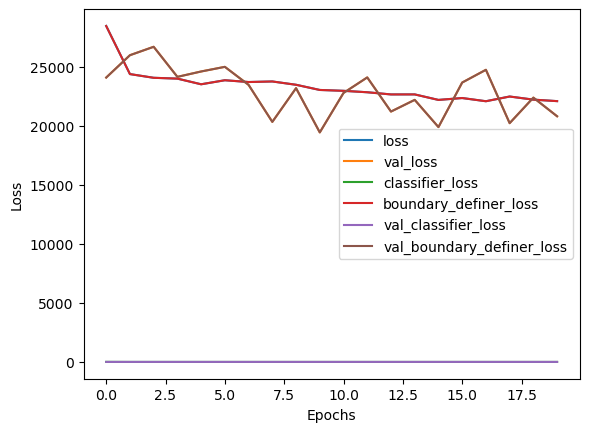

In [66]:
# Plotting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['classifier_loss'])
plt.plot(history.history['boundary_definer_loss'])
plt.plot(history.history['val_classifier_loss'])
plt.plot(history.history['val_boundary_definer_loss'])
plt.legend(['loss', 'val_loss', 'classifier_loss', 'boundary_definer_loss', 'val_classifier_loss', 'val_boundary_definer_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

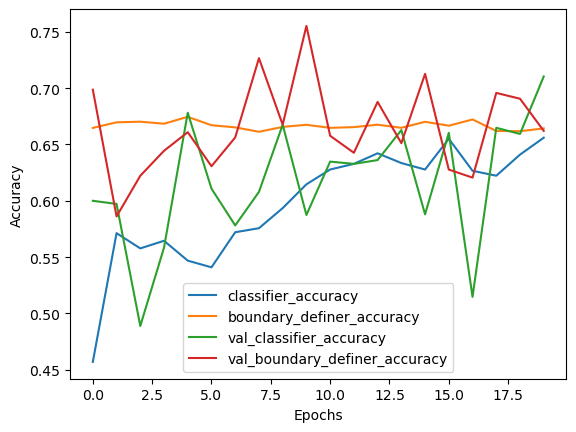

In [67]:
# Plotting
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.plot(history.history['classifier_accuracy'])
plt.plot(history.history['boundary_definer_accuracy'])
plt.plot(history.history['val_classifier_accuracy'])
plt.plot(history.history['val_boundary_definer_accuracy'])
plt.legend(['classifier_accuracy', 'boundary_definer_accuracy', 'val_classifier_accuracy', 'val_boundary_definer_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

(2, 468, 143, 137, 81)


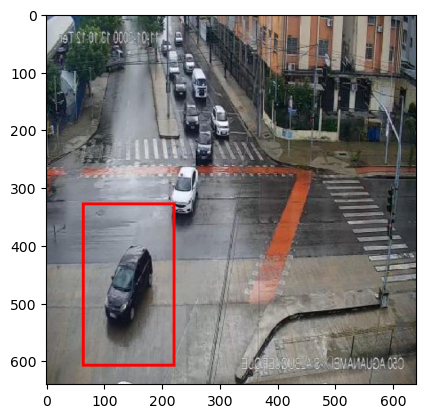

In [68]:
test_images = os.listdir(f'{test_folder}/images')
test_labels = os.listdir(f'{test_folder}/labels')
test_image, test_objects_coords = load_image(test_folder, test_images, test_labels, 4)
upscaled_coords = upscale_points(test_image, test_objects_coords[0], False)
print(upscaled_coords)
modified_image = test_image.copy()
modified_image, coords = draw_boundary(modified_image, [255, 0, 0], test_objects_coords[0], False)
plt.imshow(modified_image)

(1, 64, 64, 3)


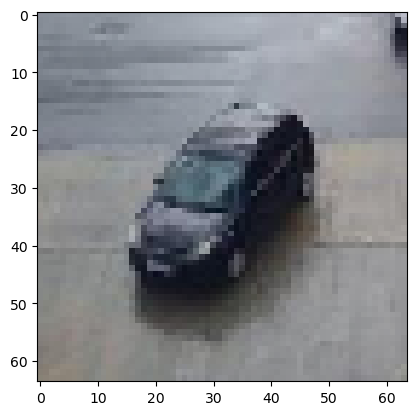

In [69]:
test_cropped_image = resize_region(test_image, upscaled_coords)
plt.imshow(test_cropped_image)
test_cropped_image = np.reshape(test_cropped_image, (1, 64, 64, 3))
print(test_cropped_image.shape)

In [70]:
predictions = model.predict(test_cropped_image)

1/1 [==============================] - 0s 114ms/step


[[0. 1. 0. 0.]]
2 (640, 0, 0, 0)


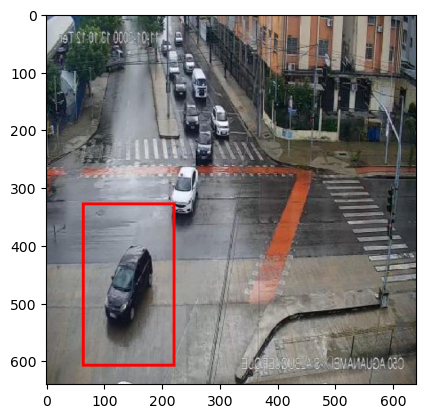

In [71]:
predicted_class = np.argmax(predictions[0])
print(predictions[1])
print(predicted_class, upscale_points(test_image, np.squeeze(predictions[1]), True))
modified_image = draw_boundary(modified_image, [0, 255, 0], np.squeeze(predictions[1]), True)
plt.imshow(modified_image)